# Ensemble Modeling

In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, make_scorer, fbeta_score, RocCurveDisplay, DetCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

np.random.seed(1000)

## Load Data

In [330]:
def read_dataset(name):
  df_train = pd.read_csv(f"../data/modeling/data_{name}_train.csv")
  df_test = pd.read_csv(f"../data/modeling/data_{name}_test.csv")

  X_train = df_train.drop(columns="Abnormal")
  X_test = df_test.drop(columns="Abnormal")
  y_train = df_train.Abnormal
  y_test = df_test.Abnormal

  return X_train, X_test, y_train, y_test

X_1da_train, X_1da_test, y_train, y_test = read_dataset("1da")
X_reduced_train, X_reduced_test, _, _ = read_dataset("reduced")
X_expanded_train, X_expanded_test, _, _ = read_dataset("expanded")

In [331]:
print(PCA().fit(StandardScaler().fit_transform(X_1da_train)).explained_variance_ratio_.cumsum())
print(PCA().fit(StandardScaler().fit_transform(X_reduced_train)).explained_variance_ratio_.cumsum())
print(PCA().fit(StandardScaler().fit_transform(X_expanded_train)).explained_variance_ratio_.cumsum())

[0.39700735 0.63287608 0.74650163 0.81383242 0.87050126 0.91141341
 0.94993668 0.97485904 0.99264176 0.99879509 0.99945779 1.
 1.         1.         1.         1.         1.        ]
[0.32791273 0.51208771 0.6540545  0.75887394 0.84755584 0.91181186
 0.95587616 0.98700267 1.         1.        ]
[0.31920099 0.50542221 0.64004963 0.73758345 0.80557019 0.86127851
 0.90377085 0.92985204 0.94274255 0.95351873 0.96139636 0.96673013
 0.97118342 0.97523752 0.97880062 0.98191657 0.98471403 0.98708323
 0.98909252 0.99086671 0.9924575  0.99349598 0.99447301 0.99533795
 0.99601222 0.99658622 0.99701223 0.99741953 0.99777589 0.99811357
 0.99839581 0.99861115 0.99882032 0.9990078  0.99917539 0.99930616
 0.99942135 0.99952421 0.99961496 0.99969725 0.99975768 0.99981002
 0.99985646 0.99990023 0.99993251 0.99995385 0.99997388 0.99998558
 0.99998963 0.99999327 0.99999659 0.99999895 1.         1.
 1.         1.         1.         1.         1.         1.        ]


## Model Configuration

In [332]:
train_features = {
  "gbt_1da": X_1da_train,
  "gbt_red": X_reduced_train,
  "gbt_exp": X_expanded_train,
  "gbt_pca_1da": X_1da_train,
  "gbt_pca_red": X_reduced_train,
  "gbt_pca_exp": X_expanded_train,
}

test_features = {
  "gbt_1da": X_1da_test,
  "gbt_red": X_reduced_test,
  "gbt_exp": X_expanded_test,
  "gbt_pca_1da": X_1da_test,
  "gbt_pca_red": X_reduced_test,
  "gbt_pca_exp": X_expanded_test,
}

def make_gbt_config(pca_n_components = None):
  config = {
    "clf": XGBClassifier(n_jobs=-1, eval_metric=make_scorer(fbeta_score, beta=2),
                         n_estimators=1000, learning_rate=0.01, reg_lambda=100, max_depth=5, colsample_bynode=0.5, subsample=0.5, max_delta_step=3, gamma=10),
    "param_grid": {
      # "clf__n_estimators": [250, 500, 1000],
      # "clf__learning_rate": [round(x, 4) for x in np.logspace(-7, -2, 4)],
      # "clf__reg_lambda": [10, 100, 100],
      # "clf__max_depth": [1, 2, 3, 4],
      # "clf__colsample_bynode": [0.2, 0.3, 0.5],
      # "clf__subsample": [0.2, 0.3, 0.5],
      # "clf__max_delta_step": [3, 5, 8],
      # "clf__gamma": [10, 12, 16, 20],
    }
  }

  if pca_n_components is not None:
    config["param_grid"]["pca__n_components"] = pca_n_components
  return config

model_configs = {
  "gbt_1da": make_gbt_config(),
  "gbt_red": make_gbt_config(),
  "gbt_exp": make_gbt_config(),
  "gbt_pca_1da": make_gbt_config([6, 7, 8, 9, 10]),
  "gbt_pca_red": make_gbt_config([6, 7, 8]),
  "gbt_pca_exp": make_gbt_config([6, 8, 10, 12])
}

## Training

In [333]:
def perform_grid_search_fit(model_config, X_fit, y_fit):
  clf = model_config["clf"]
  param_grid = model_config["param_grid"]

  pipe_steps = [
    ("scaler", StandardScaler()),
    ("clf", clf)
  ]

  if "pca" in name:
    pipe_steps.insert(1, ("pca", PCA()))

  pipe = Pipeline(pipe_steps)
  kf = StratifiedKFold(n_splits=10)
  search = GridSearchCV(pipe, param_grid, cv=kf,  n_jobs=-1, refit=True)
  # search = RandomizedSearchCV(pipe, param_grid, cv=kf, n_iter=10, n_jobs=-1, refit=True, verbose=3)
  search.fit(X_fit, y_fit)

  return (search.best_estimator_, search.best_params_)

best_models = {}
for name, model_config in model_configs.items():
  X_train = train_features[name]
  best_model, best_params = perform_grid_search_fit(model_config, X_train, y_train)
  print(f"Best params for model {name}: {best_params}")
  best_models[name] = {
    "model": best_model,
    "params": best_params
  }

Best params for model gbt_1da: {}
Best params for model gbt_red: {}
Best params for model gbt_exp: {}
Best params for model gbt_pca_1da: {'pca__n_components': 10}
Best params for model gbt_pca_red: {'pca__n_components': 8}
Best params for model gbt_pca_exp: {'pca__n_components': 12}


## Feature Importances

In [346]:
imps_df = pd.DataFrame(index=X_expanded_train.columns)
for name, best_model in best_models.items():
  mod = best_model["model"]
  params = best_model["params"]
  X_train = train_features[name]
  if "pca" not in name:
    imps = mod.named_steps["clf"].feature_importances_
    imps = pd.Series(imps, index=X_train.columns, name=name)
    imps_df = imps_df.merge(imps, how="left", left_index=True, right_index=True)

display(imps_df)

,gbt_1da,gbt_red,gbt_exp
ACWO_1,0.062652,0.108940,0.028123
ACWO_2,NaN,NaN,0.023178
ACWO_3,NaN,NaN,0.023457
ACWO_4,NaN,NaN,0.021986
ACWO_5,NaN,NaN,0.024003
ACWO_6,NaN,NaN,0.025393
ADMO_1,0.046177,0.066504,0.010599
ADMO_2,NaN,NaN,0.011849
ADMO_3,NaN,NaN,0.014052
ADMO_4,NaN,NaN,0.014166


## Train Evaluation

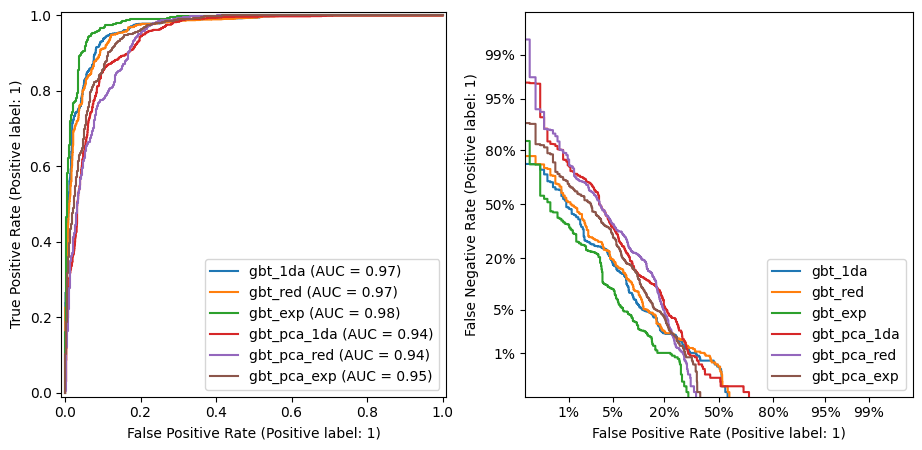

In [341]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, best_model in best_models.items():
  mod = best_model["model"]
  params = best_model["params"]
  X_train = train_features[name]
 
  RocCurveDisplay.from_estimator(mod, X_train, y_train, ax=ax_roc, name=name)
  DetCurveDisplay.from_estimator(mod, X_train, y_train, ax=ax_det, name=name)

In [336]:
mod_thresh = {}
for name, best_model in best_models.items():
  mod = best_model["model"]
  X_train = train_features[name]
  y_prob = mod.predict_proba(X_train)[:,1]
  
  t_iter = []
  f2_iter = []

  thres = [x/100 for x in np.linspace(0, 100, 101)]
  opt_thres = -1
  max_f2 = -1
  for t in thres:
    pred_y = [0 if p < t else 1 for p in y_prob]
    prec, rec, f2, _ = precision_recall_fscore_support(y_train, pred_y, beta=2, average="binary", zero_division=0)
    if f2 > max_f2: 
      max_f2 = f2
      opt_thres = t
      
  print(f"{name} - Opt thresh: {opt_thres}")
  mod_thresh[name] = opt_thres

gbt_1da - Opt thresh: 0.35
gbt_red - Opt thresh: 0.36
gbt_exp - Opt thresh: 0.38
gbt_pca_1da - Opt thresh: 0.29
gbt_pca_red - Opt thresh: 0.33
gbt_pca_exp - Opt thresh: 0.38


## Test Evaluation

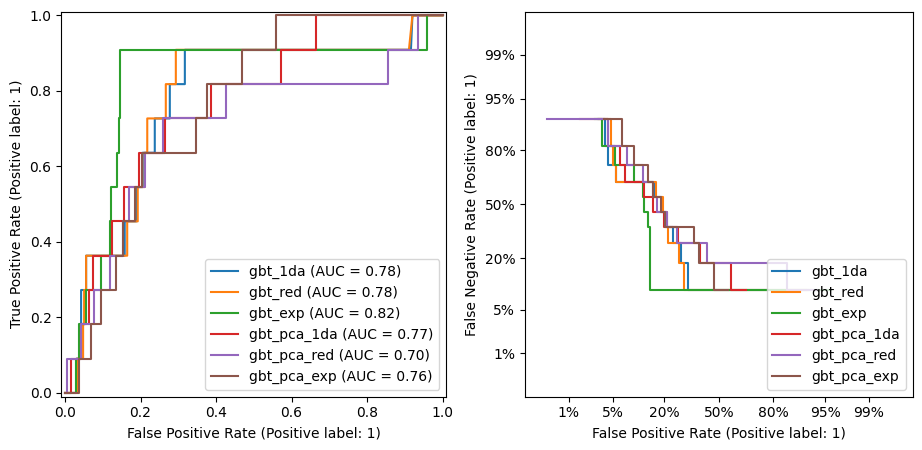

In [337]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, best_model in best_models.items():
  mod = best_model["model"]
  params = best_model["params"]
  X_test = test_features[name]
 
  RocCurveDisplay.from_estimator(mod, X_test, y_test, ax=ax_roc, name=name)
  DetCurveDisplay.from_estimator(mod, X_test, y_test, ax=ax_det, name=name)

gbt_1da - precision: 0.03521, recall: 0.4545, f2: 0.1344
gbt_red - precision: 0.03497, recall: 0.4545, f2: 0.1337
gbt_exp - precision: 0.06306, recall: 0.6364, f2: 0.2258
gbt_pca_1da - precision: 0.03361, recall: 0.7273, f2: 0.1418
gbt_pca_red - precision: 0.03553, recall: 0.6364, f2: 0.1452
gbt_pca_exp - precision: 0.04023, recall: 0.6364, f2: 0.1606


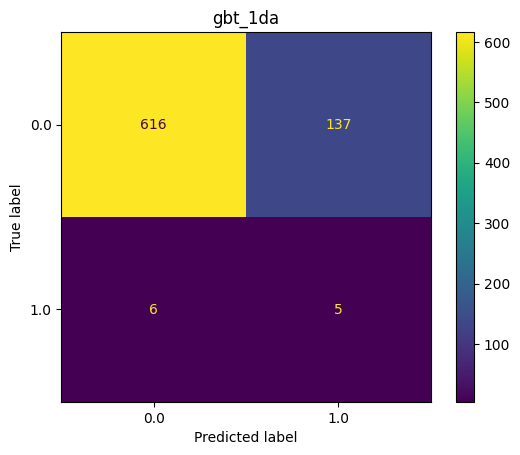

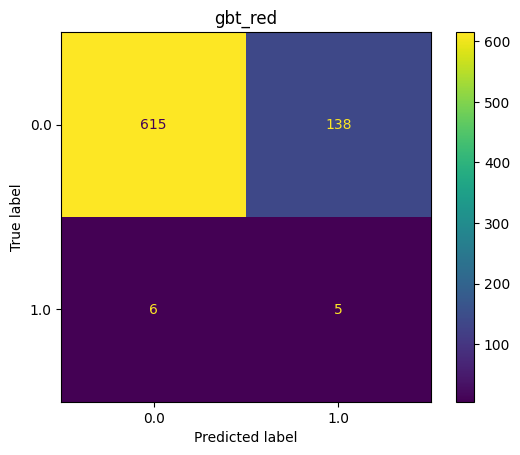

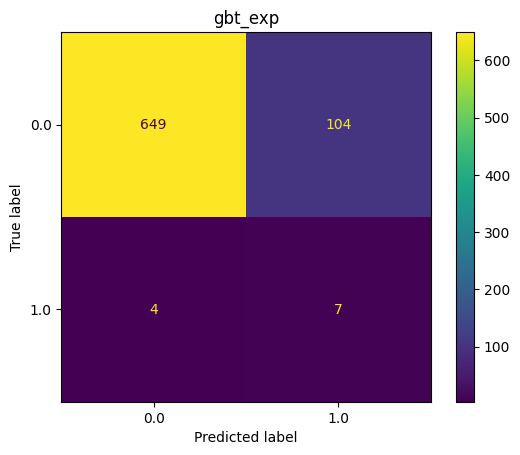

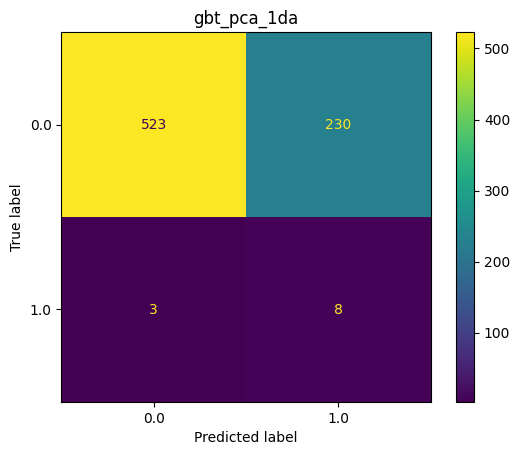

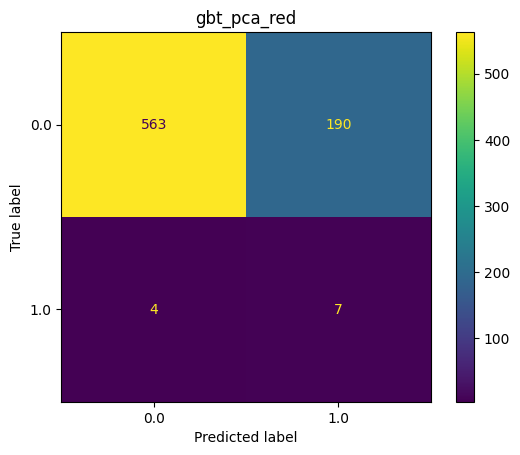

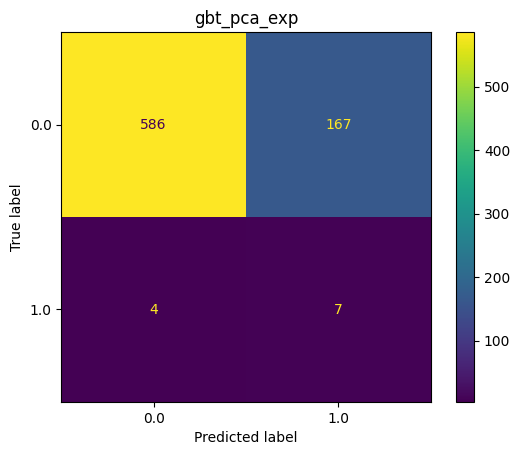

In [338]:
for name, best_model in best_models.items():
  mod = best_model["model"]
  X_test = test_features[name]

  # test_pred = mod.predict(X_test)
  test_prob = mod.predict_proba(X_test)[:,1]
  test_pred = [0 if p < mod_thresh[name] else 1 for p in test_prob]

  p, r, f2, supp = precision_recall_fscore_support(y_test, test_pred, average="binary", beta=2, pos_label=1.0, zero_division=0)
  print(f"{name} - precision: {p:.4}, recall: {r:.4}, f2: {f2:.4}")

  disp = ConfusionMatrixDisplay.from_predictions(y_test, test_pred)
  disp.ax_.set_title(name)